# Feature engineering with Pandas

## Импорты 

In [5]:
import yaml

with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:

# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
# from xgboost import XGBRegressor

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [9]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'  
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
cfg = {
    'house_pricing': {
        'test_dataset': 'kaggle_house_prices.tar/test.csv'  
    }
}
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Не все столбцы здесь выведены. Их список мы можем получить, используя аттрибут `columns`:

In [11]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Почистим данные в нескольких столбцах, основываясь на data_description

In [12]:
train_df["Exterior2nd"] = train_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].where(train_df.GarageYrBlt <= 2010, train_df.YearBuilt)
    # Names beginning with numbers are awkward to work with
train_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [13]:
cat_df = train_df.select_dtypes(include=['object'])

In [15]:
num_df = train_df.select_dtypes(exclude=['object'])


In [16]:
num_сols_with_missing = [col for col in num_df.columns 
                                 if num_df[col].isnull().any()]


In [17]:
cat_сols_with_missing = [col for col in cat_df.columns 
                                 if cat_df[col].isnull().any()]

In [18]:
train_df[cat_сols_with_missing] = train_df[cat_сols_with_missing].fillna('NAN')

In [19]:
train_df.drop(['GarageYrBlt','TotRmsAbvGrd','FirstFlrSF','GarageCars'], axis=1, inplace=True)

In [20]:
my_imputer = SimpleImputer()

train_df[num_сols_with_missing] = my_imputer.fit_transform(train_df[num_сols_with_missing])

In [21]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NAN,Reg,Lvl,AllPub,...,0,NAN,NAN,NAN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NAN,Reg,Lvl,AllPub,...,0,NAN,NAN,NAN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NAN,IR1,Lvl,AllPub,...,0,NAN,NAN,NAN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NAN,IR1,Lvl,AllPub,...,0,NAN,NAN,NAN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NAN,IR1,Lvl,AllPub,...,0,NAN,NAN,NAN,0,12,2008,WD,Normal,250000


In [22]:
cat_df = train_df.select_dtypes(include=['object'])
cat_df.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [23]:
train_df.LandContour.value_counts()

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

В нашем наборе достаточно много категориальных признаков, и использовать их в таком виде, как они представлены в датасете, скорее всего нельзя. Это связано с тем, что модели в большинстве своем работают с евклидовыми или метрическими пространствами. Для перевода категориальных признаков в них используются различные техники, рассмотрим некоторые из них

# Label Encoding

Естественным решением такой проблемы было бы однозначное отображение каждого значения в уникальное число. К примеру, мы могли бы преобразовать признак Street так: Pave в 0, а Grvl в 1. Эту простую операцию приходится делать часто, поэтому в модуле sklearn.preprocessing  именно для этой задачи реализован класс LabelEncoder. 

Метод fit этого класса находит все уникальные значения признака и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения.

<Axes: ylabel='LandContour'>

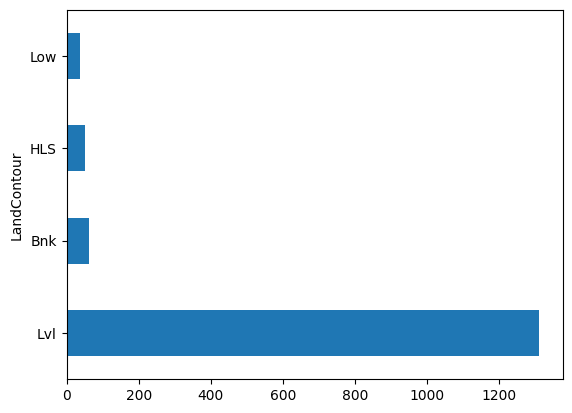

In [24]:
train_df.LandContour.value_counts().plot.barh()

<Axes: ylabel='Count'>

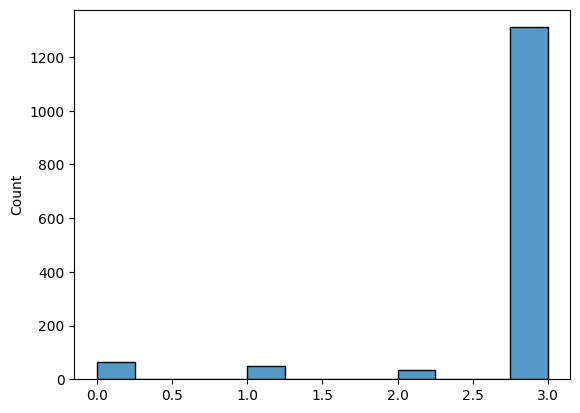

In [25]:
label_encoder = LabelEncoder()

encoded_neigh = pd.Series(label_encoder.fit_transform(train_df['LandContour']))
sns.histplot(encoded_neigh )

<Axes: ylabel='Count'>

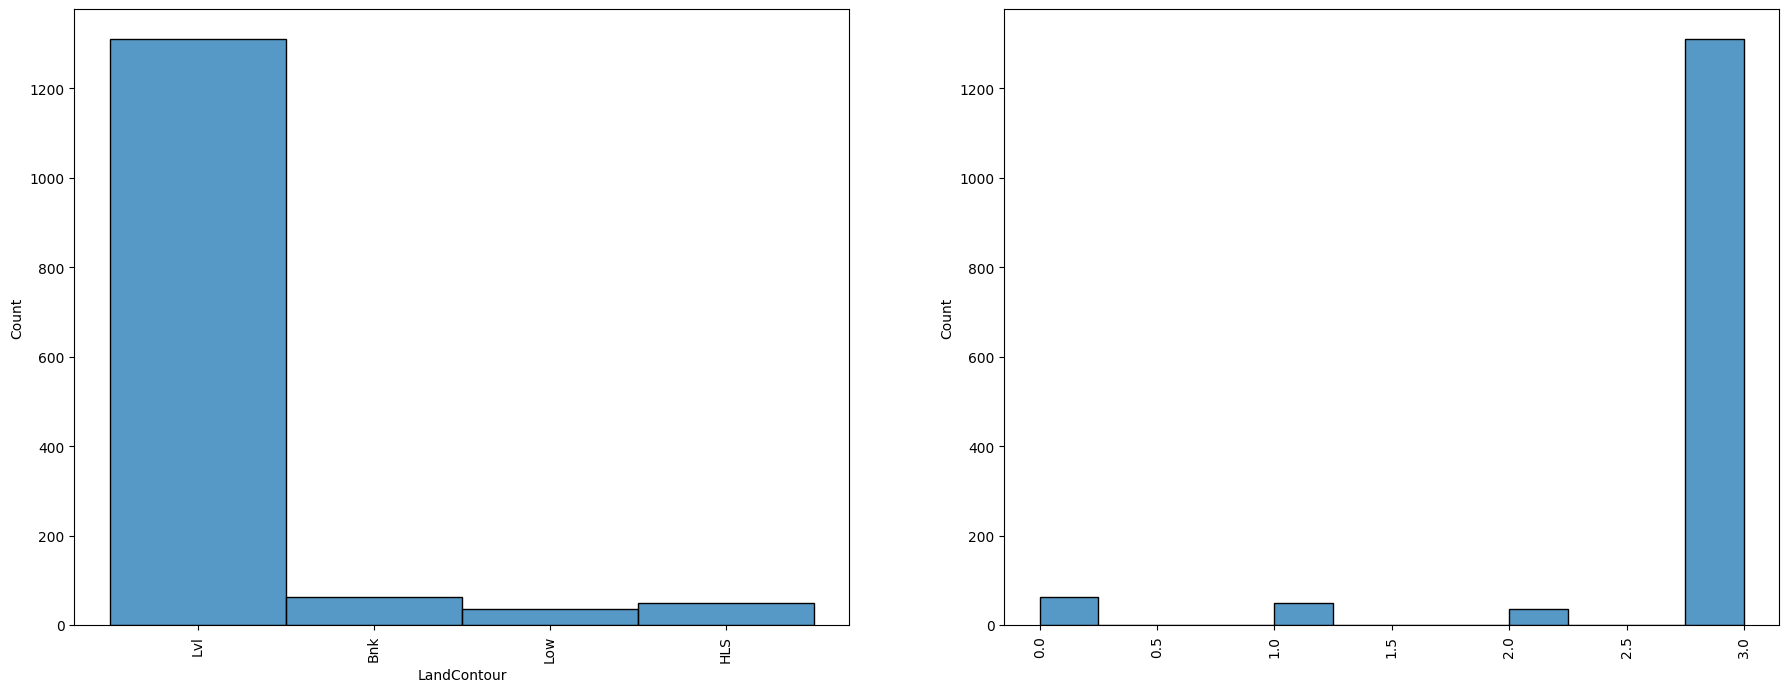

In [26]:
fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.histplot(train_df['LandContour'], ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.histplot(encoded_neigh, ax=axes[1] )

In [27]:
print(dict(enumerate(label_encoder.classes_)))

{0: 'Bnk', 1: 'HLS', 2: 'Low', 3: 'Lvl'}


Вопрос: Что произойдет, если у нас появятся данные с другими категориями? LabelEncoder выдаст ошибку, что в словаре нет такой категории

In [28]:
label_encoder.transform(train_df['LandContour'].replace('Low', 'low'))

ValueError: y contains previously unseen labels: 'low'

Таким образом, при использовании этого метода нужно быть уверенным, что признак не может принимать неизвестных ранее значений.  Вопрос: как можно эту проблему решить?

Основная проблема такого представления заключается даже не в этом, а в том, что числовой код создал евклидово представление для данных. Это значит, что теперь можно вычесть "Low" из "Bnk" и тд. Поэтому, например, методы, основанные на расстоянии, становятся больше неприменимы.

LabelEncoding не принимает во внимание порядок переменных. Поэтому, если на самом деле известно, в каком порядке должны располагаться категории, лучше использовать другой метод энкодинга, например, порядковый. 


**Задание**: Закодируйте все категориальные переменные джля обучающего и тестового датасетов с помощью Label Encoding. При этом: сначала обучите на обучающем и примените на тестовом, потом наоборот. Появятся ли ошибки из-за неизвестных категорий? 
Найдите параметр, контролирующий это поведение. 

In [29]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

cat_cols = df.select_dtypes(include=['object']).columns

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

print("Вариант 1: Обучаем на train, применяем к train и test")
encoder.fit(train_df[cat_cols])
train_encoded1 = encoder.transform(train_df[cat_cols])
test_encoded1 = encoder.transform(test_df[cat_cols])
print(f"Train: {train_encoded1[:5, :3]}...")
print(f"Test: {test_encoded1[:5, :3]}...")
print(f"Уникальные значения в test: {np.unique(test_encoded1)}")
print("Ошибок нет благодаря handle_unknown='use_encoded_value'\n")

print("Вариант 2: Обучаем на test, применяем к test и train")
encoder.fit(test_df[cat_cols])
test_encoded2 = encoder.transform(test_df[cat_cols])
train_encoded2 = encoder.transform(train_df[cat_cols])
print(f"Test: {test_encoded2[:5, :3]}...")
print(f"Train: {train_encoded2[:5, :3]}...")
print(f"Уникальные значения в train: {np.unique(train_encoded2)}")
print("Ошибок нет, но в train появились значения -1 для неизвестных категорий\n")

print("Тестирование с handle_unknown='error'")
error_encoder = OrdinalEncoder(handle_unknown='error')
error_encoder.fit(train_df[cat_cols])

try:
    test_encoded_error = error_encoder.transform(test_df[cat_cols])
except ValueError as e:
    print(f"Ошибка при преобразовании тестовых данных: {str(e)[:100]}...")

print("\nКонтролирующий параметр: handle_unknown")
print("Возможные значения:")
print("- 'error': вызовет ошибку при обнаружении неизвестной категории")
print("- 'use_encoded_value': заменит неизвестные категории на значение unknown_value (по умолчанию -1)")

Вариант 1: Обучаем на train, применяем к train и test
Train: [[ 3.  1. nan]
 [ 4.  1. nan]
 [ 1.  1. nan]
 [ 3.  1. nan]
 [ 3.  1. nan]]...
Test: [[ 3.  1. nan]
 [ 3.  1. nan]
 [ 4.  1.  0.]
 [ 4.  1. nan]
 [ 3.  1. nan]]...
Уникальные значения в test: [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. nan]
Ошибок нет благодаря handle_unknown='use_encoded_value'

Вариант 2: Обучаем на test, применяем к test и train
Test: [[ 3.  1. nan]
 [ 3.  1. nan]
 [ 4.  1.  0.]
 [ 4.  1. nan]
 [ 3.  1. nan]]...
Train: [[ 3.  1. nan]
 [ 4.  1. nan]
 [ 1.  1. nan]
 [ 3.  1. nan]
 [ 3.  1. nan]]...
Уникальные значения в train: [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. nan]
Ошибок нет, но в train появились значения -1 для неизвестных категорий

Тестирование с handle_unknown='error'
Ошибка при преобразовании тестовых данных: Found unknown categories ['PosA', 'RRNn'] in column 10 during 

**Задание**: Используйте Ordinal Encoding для признака MS_Zoning. Задайте категории автоматически и подайте как параметр. Будут ли они закодированы одинаково или нет?

In [30]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

mszoning_data = df[['MSZoning']].copy()

all_categories = sorted(mszoning_data['MSZoning'].dropna().unique())
print("Все уникальные категории:", all_categories)

encoder = OrdinalEncoder(
    categories=[all_categories],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

encoded = encoder.fit_transform(mszoning_data)
mszoning_data['Encoded'] = encoded

print("\nЗакодированные значения:")
print(mszoning_data.head(10))

mapping = {cat: code for cat, code in zip(all_categories, range(len(all_categories)))}
print("\nСоответствие категорий и кодов:")
for cat, code in mapping.items():
    print(f"{cat}: {code}")

consistent = True
for _, row in mszoning_data.iterrows():
    if not pd.isna(row['MSZoning']):
        if row['Encoded'] != mapping[row['MSZoning']]:
            consistent = False
            print(f"Несоответствие: {row['MSZoning']} -> {row['Encoded']} (должно быть {mapping[row['MSZoning']]})")

print("\nВсе категории закодированы одинаково?", consistent)

Все уникальные категории: ['C (all)', 'FV', 'RH', 'RL', 'RM']

Закодированные значения:
  MSZoning  Encoded
0       RL      3.0
1       RL      3.0
2       RL      3.0
3       RL      3.0
4       RL      3.0
5       RL      3.0
6       RL      3.0
7       RL      3.0
8       RM      4.0
9       RL      3.0

Соответствие категорий и кодов:
C (all): 0
FV: 1
RH: 2
RL: 3
RM: 4

Все категории закодированы одинаково? True


# One Hot encoding 

One Hot encoding является наиболее распространенным подходом для преобразования категориальных признаков, и он работает очень хорошо, если ваша категориальная переменная принимает небольшое количество значений (т.е. вы, как правило, не будете этого делать для переменных, которые принимают более 15 различных значений)

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае One Hot Encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. На позицию, соответствующую численному значению признака мы помещаем 1.
Этот метод реализован в sklearn.preprocessing в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей. Однако в нашем случае размер данных не является проблемой, поэтому мы будем использовать "плотное" представление.


In [31]:
onehot_encoder = OneHotEncoder(sparse_output=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(cat_df))
encoded_categorical_columns.head()


,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,266
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Как видно, у нас получилось  268 столбцов - именно столько уникальных значений могут принимать категориальные столбцы. Список категорий можно посмотреть с помощью `onehot_encoder.categories_`

In [32]:
onehot_encoder.categories_

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['Grvl', 'NAN', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['AllPub', 'NoSeWa'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
       dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=obj

Кроме того, можно сразу удалить категории, которые встречаются редко. Это можно сделать, задав значение параметра min_frequency

In [33]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=0.3)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(cat_df))
encoded_categorical_columns.head()


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Кроме sklearn Pandas предлагает удобную функцию get_dummies для получения One Hot Encoding-а. Его минус в том, что нельзя с помощью transform менять новые наборы данных.

In [34]:
pd.get_dummies(cat_df).head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NAN,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
4,False,False,False,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False


Используя OneHotEncoder, мы можем четко контролировать, что происходит, когда он сталкивается с новой категорией. Если мы думаем, что это невозможно, то мы можем сказать ему, чтобы он выдал ошибку с handle_unknown="error"; в противном случае мы можем указать ему просто установить значения во всех "известных" столбцах в 0, с помощью handle_unknown="ignore".

In [35]:
temp_df = cat_df.copy()
temp_df['LandContour'] = temp_df['LandContour'].replace('Low', 'low')

In [36]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=0.3, handle_unknown="ignore")
onehot_encoder.fit(cat_df)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.transform(temp_df))
encoded_categorical_columns.head()


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Как видно, признаков получается очень и очень много (столько же, сколько и категорий). Однако есть способ использовать более плотное представление, а именно бинарное. Этот метод комбинирует LabelEncoding и BinaryEncoding. Обнако, широко он не используется. Пофантазируйте, почему это может быть?

**Задание**: Определите, сколько столбцов получится после Binary Encoding.

In [37]:
import math

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])
cat_cols = df.select_dtypes(include=['object']).columns
cat_df = df[cat_cols].copy()

def manual_binary_encoding(df, min_frequency=0.3):
    result_df = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        value_counts = df[col].value_counts(normalize=True)
        frequent_categories = value_counts[value_counts >= min_frequency].index.tolist()

        temp_col = df[col].where(df[col].isin(frequent_categories), 'RARE_CATEGORY')

        unique_cats = sorted(temp_col.unique())
        ordinal_map = {cat: i for i, cat in enumerate(unique_cats)}
        encoded = temp_col.map(ordinal_map).astype(int)

        n_categories = len(unique_cats)
        n_bits = math.ceil(math.log2(n_categories)) if n_categories > 1 else 1

        for bit in range(int(n_bits)):
            bit_col = (encoded.values >> bit) & 1
            result_df[f"{col}_bit{bit}"] = bit_col
    
    return result_df

min_freq = 0.3
binary_encoded_df = manual_binary_encoding(cat_df, min_frequency=min_freq)

print(f"Исходное количество категориальных признаков: {len(cat_cols)}")
print(f"Количество столбцов после Binary Encoding: {binary_encoded_df.shape[1]}")
print(f"Первые 5 строк преобразованных данных:")
print(binary_encoded_df.head())

Исходное количество категориальных признаков: 43
Количество столбцов после Binary Encoding: 52
Первые 5 строк преобразованных данных:
   MSZoning_bit0  Street_bit0  Alley_bit0  Alley_bit1  LotShape_bit0  \
0              1            0           0           1              0   
1              1            0           0           1              0   
2              1            0           0           1              0   
3              1            0           0           1              0   
4              1            0           0           1              0   

   LotShape_bit1  LandContour_bit0  Utilities_bit0  LotConfig_bit0  \
0              1                 0               0               0   
1              1                 0               0               1   
2              0                 0               0               0   
3              0                 0               0               1   
4              0                 0               0               1   

   LandSlope

# Target Encoding

Target Encoding аналогичен label encoding-у, за исключением того, что здесь значения коррелируют непосредственно с целевой переменной. Среднее значение кода для каждой категории в лейбле элемента определяется средним значением целевой переменной на обучающих данных. Этот метод кодирования выявляет связь между аналогичными категориями, но отношения ограничены внутри категорий и цели.

Преимущество этого метода кодирования заключается в том, что оно не влияет на объем данных и помогает в более быстром обучении. Часто обеспечивает более высокую точность (иногда резко высокую точность) из-за прямой корреляции между закодированной переменной и целевой.


Самый простой способ сделать такое кодирование - присвоить категории среднее значение таргета для нее. Это обучаемый метод, т.к. мы используем выходы нашего моделирования для построения кодирования. Кстати, на самом деле необяхательно использовать настоящий таргет)

**Задание**: Покажите, что происходит, когда этот метод применяется к постоянному предиктору.

In [38]:
cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

print("Уникальные значения LandContour и их количество:")
print(train_df['LandContour'].value_counts())

train_df["LandContour_encoded"] = train_df.groupby('LandContour')["SalePrice"].transform("mean")

train_df["Constant_Feature"] = "A"

train_df["Constant_Feature_encoded"] = train_df.groupby('Constant_Feature')["SalePrice"].transform("mean")

print("\nРезультаты для LandContour:")
print(train_df[["LandContour", "SalePrice", "LandContour_encoded"]].head(10))

print("\nРезультаты для Constant Feature:")
print(train_df[["Constant_Feature", "SalePrice", "Constant_Feature_encoded"]].head(10))

print("\nАнализ:")
print(f"Среднее значение SalePrice: {train_df['SalePrice'].mean():.2f}")
print(f"3начение для Constant Feature: {train_df['Constant_Feature_encoded'].iloc[0]:.2f}")

Уникальные значения LandContour и их количество:
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

Результаты для LandContour:
  LandContour  SalePrice  LandContour_encoded
0         Lvl     208500        180183.746758
1         Lvl     181500        180183.746758
2         Lvl     223500        180183.746758
3         Lvl     140000        180183.746758
4         Lvl     250000        180183.746758
5         Lvl     143000        180183.746758
6         Lvl     307000        180183.746758
7         Lvl     200000        180183.746758
8         Lvl     129900        180183.746758
9         Lvl     118000        180183.746758

Результаты для Constant Feature:
  Constant_Feature  SalePrice  Constant_Feature_encoded
0                A     208500              180921.19589
1                A     181500              180921.19589
2                A     223500              180921.19589
3                A     140000              180921.19589
4               

Однако такая кодировка создает несколько проблем. Во-первых, неизвестные категории. Может быть так, что какие-то категории просто изначально не попали в данные, а может, что их и не может быть (знакомо?). Чем можно закодировать такие категории?

Во-вторых, это редкие категории. В тех случаях, когда какая-либо категория встречается в наборе данных лишь несколько раз, любые статистические данные, рассчитанные по ней, вряд ли будут очень точными. В нашем наборе данных LandContour значение Low появляется меньше 50 раз. "Средняя" цена, которую мы рассчитали, может быть не очень репрезентативной для зданий с таким значением, которые мы можем увидеть в будущем. Target Encoding редких категорий может сделать переобучение более вероятным. 

Решением этих проблем является добавление сглаживания. Идея состоит в том, чтобы смешать среднее значение по категории с общим средним значением. Редкие категории получают меньший вес в новом значении, в то время как недостающие категории просто получают среднее по всем остальным данным.

Вопрос: А как применить это  кодирование к классификации? 

Например, в category encoders используется формула для рассчета веса 
`weight = 1/(1+exp(-(n–k)/f))`, где k - параметр minimal_samples_per_leaf, f - параметр smoothing

In [42]:
import pandas as pd
import numpy as np

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

class TargetEncoder:
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.mapping_ = {}
        self.global_mean_ = None
        
    def fit(self, X, y):
        X = pd.Series(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = y.mean()
        grouped_stats = y.groupby(X).agg(['mean', 'count'])
        for category in grouped_stats.index:
            mean = grouped_stats.loc[category, 'mean']
            count = grouped_stats.loc[category, 'count']
            smoothed_value = (count * mean + self.smoothing * self.global_mean_) / (count + self.smoothing)
            self.mapping_[category] = smoothed_value
        return self
    
    def transform(self, X):
        X = pd.Series(X)
        encoded = X.map(self.mapping_).fillna(self.global_mean_)
        return encoded

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

target_encoder = TargetEncoder(smoothing=1.0)
encoded = target_encoder.fit_transform(train_df['LandContour'], train_df['SalePrice'])
print(encoded.value_counts())

LandContour
180184.308838    1311
143694.971811      63
230541.533253      50
203046.518808      36
Name: count, dtype: int64


По умолчанию, когда встречается неизвестное значение, то оно кодируется средним по всему датасету.

In [44]:
temp_df = train_df.copy()
temp_df['LandContour'] = temp_df['LandContour'].replace('Low', 'low')
encoded = target_encoder.transform(temp_df['LandContour'])
encoded.value_counts()

LandContour
180236.011048    1311
166304.764350      63
197792.110594      50
180921.195890      36
Name: count, dtype: int64

Очень большой минус target encoding - это "протекание" таргета, так как мы используем его значения для каждого элемента через аггрегацию. С этим можно бороться несколькими путями, например, усилить регуляризацию, добавлять шум, использовать K-Fold Target Encoding.

Идея схожа с перекрестной валидацией. Мы делим данные на K-стратифицированные или случайные группы, заменяем наблюдения, присутствующие в M-й группе, на среднее целевое значение данных из всех остальных групп, кроме M-й. Мы в основном пытаемся использовать все данные, предоставленные нам, и не допускать утечки информации из целевой переменной, используя целевые зачения только из других групп для каждой категории.

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

class TargetEncoder:
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.mapping_ = {}
        self.global_mean_ = None
        
    def fit(self, X, y):
        X = pd.Series(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = y.mean()
        grouped_stats = y.groupby(X).agg(['mean', 'count'])
        for category in grouped_stats.index:
            mean = grouped_stats.loc[category, 'mean']
            count = grouped_stats.loc[category, 'count']
            smoothed_value = (count * mean + self.smoothing * self.global_mean_) / (count + self.smoothing)
            self.mapping_[category] = smoothed_value
        return self
    
    def transform(self, X):
        X = pd.Series(X)
        encoded = X.map(self.mapping_).fillna(self.global_mean_)
        return encoded

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

class NestedCVWrapper:
    def __init__(self, encoder, n_splits):
        self.encoder = encoder
        self.n_splits = n_splits
        self.kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        self.trained_encoders_ = []
        
    def fit_transform(self, X, y):
        X = pd.Series(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        encoded_values = np.zeros(len(X))
        self.trained_encoders_ = []
        
        for train_idx, val_idx in self.kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            encoder_instance = self.encoder.__class__(smoothing=self.encoder.smoothing)
            encoder_instance.fit(X_train, y_train)
            self.trained_encoders_.append(encoder_instance)
            encoded_values[val_idx] = encoder_instance.transform(X_val)
            
        return pd.Series(encoded_values)
    
    def transform(self, X):
        if not self.trained_encoders_:
            raise ValueError("Сначала нужно выполнить fit_transform для обучения энкодеров.")
        X = pd.Series(X)
        encoded_values = np.zeros(len(X))
        for encoder in self.trained_encoders_:
            encoded_values += encoder.transform(X)
        encoded_values /= len(self.trained_encoders_)
        return pd.Series(encoded_values)

target_encoder = NestedCVWrapper(TargetEncoder(smoothing=100), 4)
encoded = target_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])


In [50]:
temp_df = train_df.copy()
temp_df['LandContour'] = temp_df['LandContour'].replace('Low', 'low')
encoded = target_encoder.transform(temp_df['LandContour'])
print(encoded.value_counts())

LandContour
180251.162227    1311
168783.650246      63
194756.469456      50
180921.195890      36
Name: count, dtype: int64


# Frequency Encoding


Frequency encoding основан на замене категорий на их количество или частоту, вычисляемые на обучающем множестве. Этот метод чувствителен к выбросам, поэтому результат может быть нормализован или преобразован, например, с помощью логарифмического преобразования. Категории, которые неизвестны, могут быть заменены на 1 (в случае замены на число). Вопрос: этот метод обучаемый?

Зачем использовать этот метод? Он полезен, когда таргет зависит от редкости признака (например, если представить стоимость вина). 

Хотя это не очень вероятно, число может быть одинаковым для некоторых переменных, что может привести к коллизии - кодированию двух категорий в качестве одного и того же значения. Приведет ли это к ухудшению качества модели или к улучшению, сказать нельзя, хотя в принципе такое поведение нежелательно. 
**Вопрос**: Что делать с новыми уровнями категорий? А что, если категории имеют очень большой перекос?

In [56]:
from sklearn.model_selection import KFold

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

class CountEncoder:
    def __init__(self):
        self.counts_ = {}
        
    def fit(self, X, y=None):
        X = pd.Series(X)
        self.counts_ = X.value_counts().to_dict()
        return self
    
    def transform(self, X):
        X = pd.Series(X)
        encoded = X.map(self.counts_)
        return encoded
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

count_encoder = CountEncoder()
encoded = count_encoder.fit_transform(train_df['LandContour'], train_df["SalePrice"])
print(encoded.value_counts())

LandContour
1311    1311
63        63
50        50
36        36
Name: count, dtype: int64


По умолчанию новое значение учитывается как подсчитываемая категория, и ей дается значение 0

In [57]:
encoded = count_encoder.transform(temp_df['LandContour'])
encoded.value_counts()

LandContour
1311.0    1311
63.0        63
50.0        50
Name: count, dtype: int64

In [58]:
encoded = count_encoder.transform(temp_df['LandContour'].replace('HLS', 'low'))
encoded.value_counts()

LandContour
1311.0    1311
63.0        63
Name: count, dtype: int64

**Задание**: Создайте пайплайн/трансформер, который комбинирует несколько разных энкодингов воедино (для разных наборов признаков)

In [66]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.mapping_ = {}
        self.global_mean_ = None
        
    def fit(self, X, y):
        X = X.iloc[:, 0]
        y = pd.Series(y)
        self.global_mean_ = y.mean()
        grouped_stats = y.groupby(X).agg(['mean', 'count'])
        for category in grouped_stats.index:
            mean = grouped_stats.loc[category, 'mean']
            count = grouped_stats.loc[category, 'count']
            smoothed_value = (count * mean + self.smoothing * self.global_mean_) / (count + self.smoothing)
            self.mapping_[category] = smoothed_value
        return self
    
    def transform(self, X):
        X = X.iloc[:, 0]
        encoded = X.map(self.mapping_).fillna(self.global_mean_)
        return encoded.values.reshape(-1, 1)  # Преобразуем в 2D массив

class CountEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.counts_ = {}
        self.total_count = 0
        
    def fit(self, X, y=None):
        X = X.iloc[:, 0]
        self.counts_ = X.value_counts().to_dict()
        self.total_count = len(X)
        if self.normalize:
            for category in self.counts_:
                self.counts_[category] /= self.total_count
        return self
    
    def transform(self, X):
        X = X.iloc[:, 0]
        encoded = X.map(self.counts_)
        return encoded.values.reshape(-1, 1)  # Преобразуем в 2D массив

feature_transformers = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(smoothing=100), ['LandContour']),
        ('count', CountEncoder(normalize=True), ['Neighborhood'])
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('features', feature_transformers)
])

encoded_data = pipeline.fit_transform(train_df, train_df['SalePrice'].values)

encoded_df = pd.DataFrame(encoded_data, columns=['LandContour_encoded', 'Neighborhood_encoded'])
print(encoded_df.head())

   LandContour_encoded  Neighborhood_encoded
0        180236.011048              0.102740
1        180236.011048              0.007534
2        180236.011048              0.102740
3        180236.011048              0.034932
4        180236.011048              0.028082


# Объединение категорий

Иногда удобно объединить категории, например, если это связано с природой данных или пониманием предмета. Например, можно обхединить немколько редких категорий. Однако, иногда это не помогает, ведь мы объединяем их только по признаку редкости. Но мы можем обучить какую-нибудь маленькую модель, или объединять категории по названиям. 

**Задание**: Выберите какой-нибудь признак и объедините те категории, которые встречаются редко. Выведите график с зависимостями таргета от этих категорий до и после объединения. Оцените, как изменилось распределение.

Количество наблюдений по районам:
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

Редкие категории (менее 20 наблюдений): ['MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill', 'Blueste']


<Figure size 1600x800 with 0 Axes>

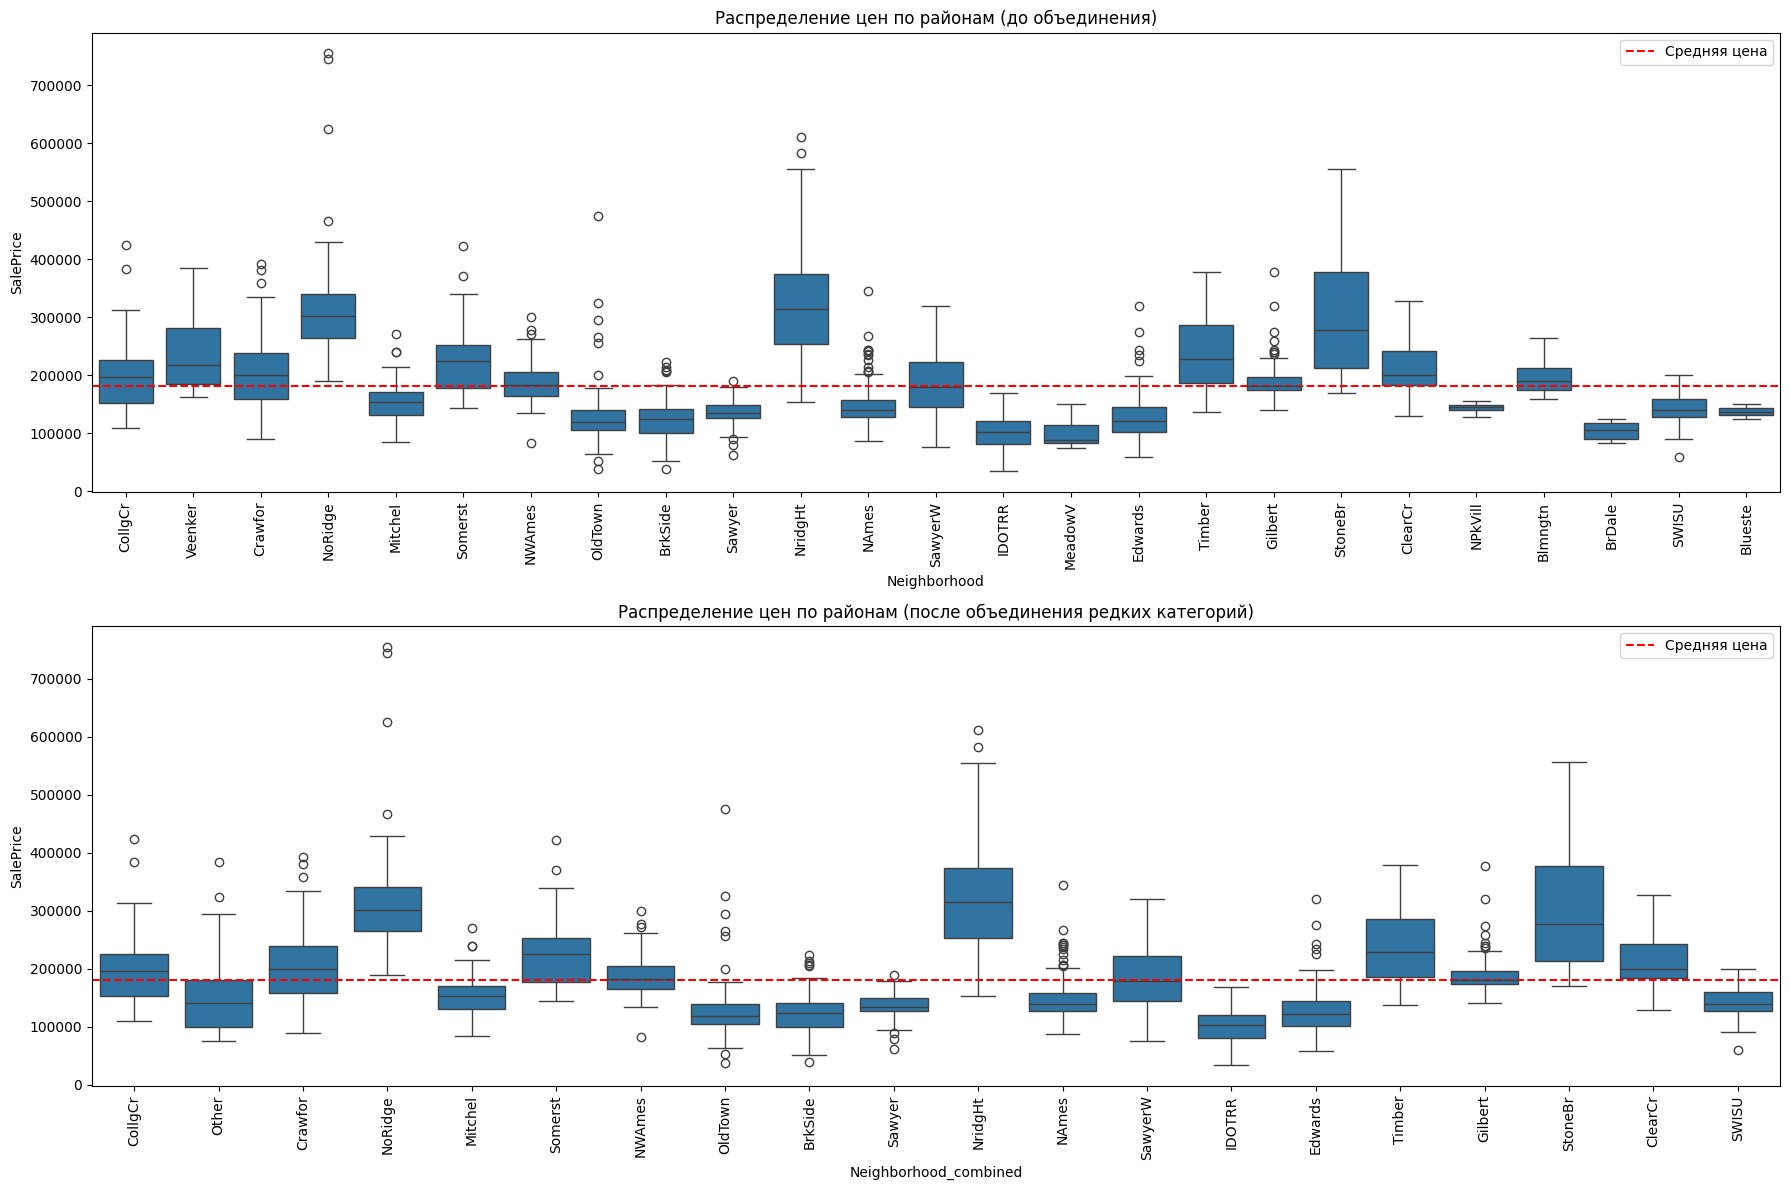


Средние цены по районам до объединения:
Neighborhood
MeadowV     98576.470588
IDOTRR     100123.783784
BrDale     104493.750000
BrkSide    124834.051724
Edwards    128219.700000
OldTown    128225.300885
Sawyer     136793.135135
Blueste    137500.000000
SWISU      142591.360000
NPkVill    142694.444444
NAmes      145847.080000
Mitchel    156270.122449
SawyerW    186555.796610
NWAmes     189050.068493
Gilbert    192854.506329
Blmngtn    194870.882353
CollgCr    197965.773333
Crawfor    210624.725490
ClearCr    212565.428571
Somerst    225379.837209
Veenker    238772.727273
Timber     242247.447368
StoneBr    310499.000000
NridgHt    316270.623377
NoRidge    335295.317073
Name: SalePrice, dtype: float64

Средние цены по районам после объединения:
Neighborhood_combined
IDOTRR     100123.783784
BrkSide    124834.051724
Edwards    128219.700000
OldTown    128225.300885
Sawyer     136793.135135
SWISU      142591.360000
NAmes      145847.080000
Other      150642.430556
Mitchel    156270.12244

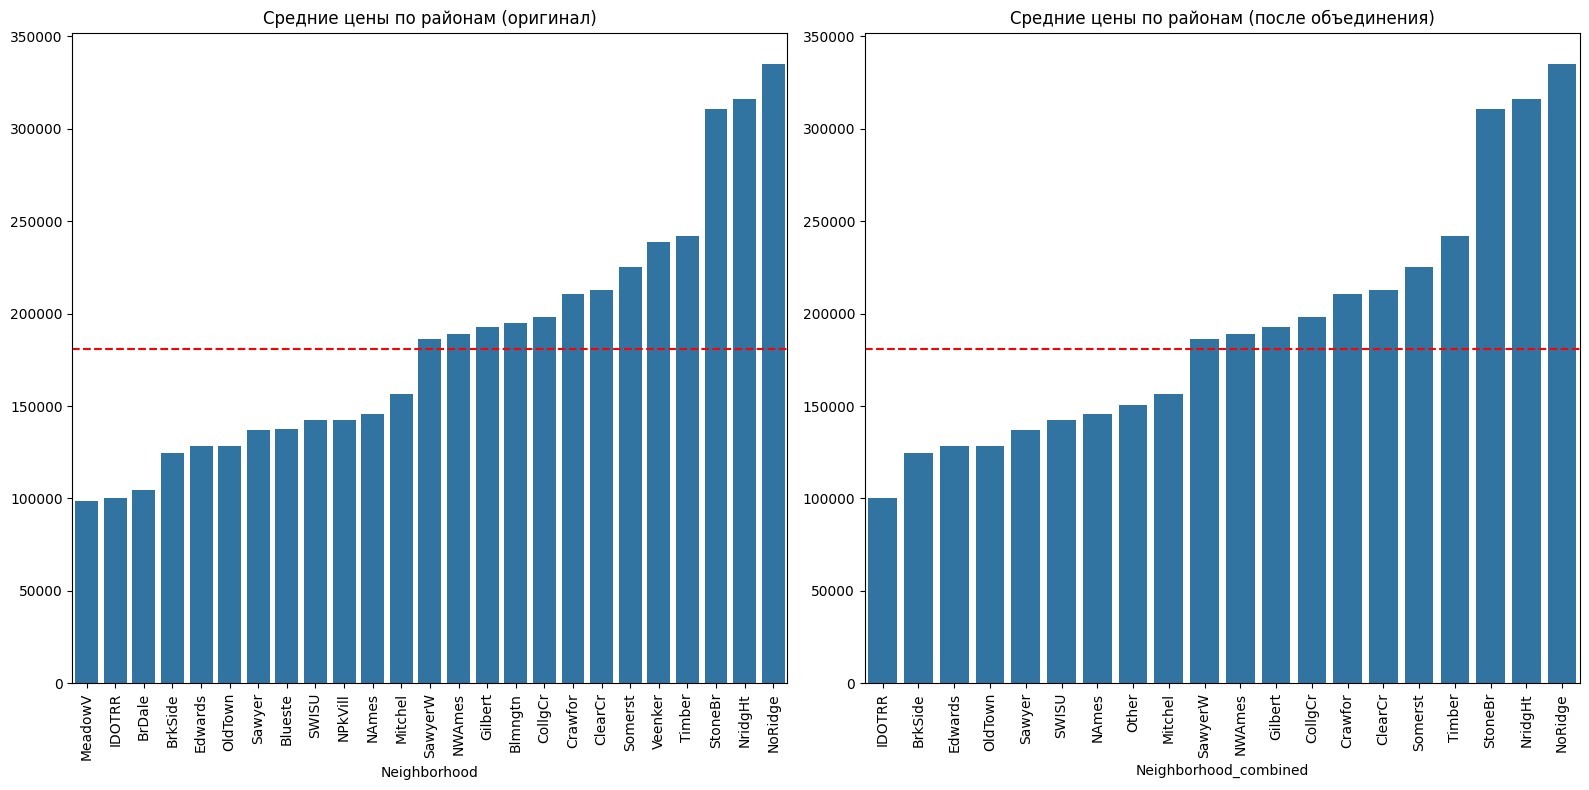

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cfg = {
    'house_pricing': {
        'train_dataset': 'kaggle_house_prices.tar/train.csv'
    }
}
df = pd.read_csv(cfg['house_pricing']['train_dataset'])

plt.figure(figsize=(16, 8))

neighborhood_counts = df['Neighborhood'].value_counts()
print("Количество наблюдений по районам:")
print(neighborhood_counts)

threshold = 20
rare_categories = neighborhood_counts[neighborhood_counts < threshold].index.tolist()
print(f"\nРедкие категории (менее {threshold} наблюдений): {rare_categories}")

df['Neighborhood_combined'] = df['Neighborhood'].apply(
    lambda x: 'Other' if x in rare_categories else x
)

plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
plt.xticks(rotation=90)
plt.title('Распределение цен по районам (до объединения)')
plt.axhline(y=df['SalePrice'].mean(), color='r', linestyle='--', label='Средняя цена')
plt.legend()

plt.subplot(2, 1, 2)
sns.boxplot(x='Neighborhood_combined', y='SalePrice', data=df)
plt.xticks(rotation=90)
plt.title('Распределение цен по районам (после объединения редких категорий)')
plt.axhline(y=df['SalePrice'].mean(), color='r', linestyle='--', label='Средняя цена')
plt.legend()

plt.tight_layout()
plt.show()

original_means = df.groupby('Neighborhood')['SalePrice'].mean().sort_values()

combined_means = df.groupby('Neighborhood_combined')['SalePrice'].mean().sort_values()

print("\nСредние цены по районам до объединения:")
print(original_means)

print("\nСредние цены по районам после объединения:")
print(combined_means)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=original_means.index, y=original_means.values)
plt.xticks(rotation=90)
plt.title('Средние цены по районам (оригинал)')
plt.axhline(y=df['SalePrice'].mean(), color='r', linestyle='--')

plt.subplot(1, 2, 2)
sns.barplot(x=combined_means.index, y=combined_means.values)
plt.xticks(rotation=90)
plt.title('Средние цены по районам (после объединения)')
plt.axhline(y=df['SalePrice'].mean(), color='r', linestyle='--')

plt.tight_layout()
plt.show()